# Synopsis of the Exercise (from Kaggle's description page)
Welcome to the year 2912, where your data science skills are needed to solve a cosmic mystery. We've received a transmission from four lightyears away and things aren't looking good.

The Spaceship Titanic was an interstellar passenger liner launched a month ago. With almost 13,000 passengers on board, the vessel set out on its maiden voyage transporting emigrants from our solar system to three newly habitable exoplanets orbiting nearby stars.

While rounding Alpha Centauri en route to its first destination—the torrid 55 Cancri E—the unwary Spaceship Titanic collided with a spacetime anomaly hidden within a dust cloud. Sadly, it met a similar fate as its namesake from 1000 years before. Though the ship stayed intact, almost half of the passengers were transported to an alternate dimension!

To help rescue crews and retrieve the lost passengers, you are challenged to predict which passengers were transported by the anomaly using records recovered from the spaceship’s damaged computer system.

Help save them and change history!

## Import the relevant libraries

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import pprint
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_bool_dtype
import seaborn as sns
import time
from matplotlib import pyplot as plt
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import KNNImputer
from scipy.stats import *
np.random.seed(42)
from numpy.random import default_rng
ranger = default_rng()

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

input_dir = "../input/spaceship-titanic/"

../input/titanic/gender_submission.csv
../input/titanic/test.csv
../input/titanic/train.csv
../input/spaceship-titanic/sample_submission.csv
../input/spaceship-titanic/test.csv
../input/spaceship-titanic/train.csv
../input/house-prices-advanced-regression-techniques/data_description.txt
../input/house-prices-advanced-regression-techniques/sample_submission.csv
../input/house-prices-advanced-regression-techniques/test.csv
../input/house-prices-advanced-regression-techniques/train.csv
../input/house-prices-advanced-regression-techniques/.ipynb_checkpoints/data_description-checkpoint.txt


## Define some useful functions

In [3]:
# bar chart percent of trasnported
def bar_chart_transported(df, col1, col2):
    '''This function takes a data frame and caculates the percentages 
    of the population matching a criterion and them presents the findings 
    in a stacked bar chart
    
    positional parameters:
    bar_chart_transported(<dataframe>, <column 1>, <column 2>)
    col2 is the dependent variable which need to be categorical True/False, 1/0, etc.'''
    index_labels = list(df[col1].unique())
    # get the outcomes programmatically
    if is_string_dtype(df[col2]):
        tval = "True"
        fval = "False"
    elif is_numeric_dtype(df[col2]):
        tval = 1
        fval = 0
    elif is_bool_dtype(df[col2]):
        tval = True
        fval = False
    else:
        return "No valid dtype in outcome column {}".format(col2)
    try:
        index_labels.sort()
    except:
        pass
    transpo_true = []
    transpo_false = []
    for i in index_labels:
        pct = df[df[col1] == i].value_counts(normalize=True, sort=False, subset=[col1,col2])
        try:
            transpo_true.append(pct[i][tval])
        except:
            transpo_true.append(0.0)
        try:
            transpo_false.append(pct[i][fval])
        except:
            transpo_false.append(0.0)
    bc_df = pd.DataFrame({
                        "Transported": transpo_true,
                        "Not Transported": transpo_false
                        },
                        index=index_labels
                        )
    bc_df.plot(kind="bar", stacked=True, figsize=(20,10), title=("Transportation by " + col1), ylabel="Percentage", fontsize=15, rot=0)  
    return bc_df

def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    cm = confusion_matrix(y, y_predict)
    plt.figure(figsize=(15,15))
    ax1= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax1, fmt='d'); #annot=True to annotate cells
    ax1.set_xlabel('Predicted labels')
    ax1.set_ylabel('True labels')
    ax1.set_title('Confusion Matrix'); 
    ax1.xaxis.set_ticklabels(['Not Transported', 'Transported'])
    ax1.yaxis.set_ticklabels(['Not Transported', 'Transported'])
    
# create a dict of models to try with a grid search
models = {
    "logr": LogisticRegression(max_iter=500),
    "dt": DecisionTreeClassifier(),
    "svm": SVC(cache_size=1000, random_state=42),
    "knn": KNeighborsClassifier(),
    "rf": RandomForestClassifier(random_state=42),
    "sgd": SGDClassifier(random_state=42) 
}
# create a matching dict of parameters for each grid search
params = {
    "logr": [{"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']},
             {"C":[0.01,0.1,1],'penalty':['l2', 'l1'], 'solver':['liblinear']},
             {"C":[0.01,0.1,1],'penalty':['l2', 'none'], 'solver':['newton-cg']}],
    "dt": {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]},
    "svm": [{'kernel':['linear','rbf', 'sigmoid'],'C': [0.01, 0.1, 1.0],'max_iter': [10000]},
            {'kernel':['poly'],'C': [0.01, 0.1, 1.0],'max_iter': [10000], 'degree':[2,3,4]},
           ],
    "knn": [{'algorithm': ['ball_tree', 'kd_tree'],
             'leaf_size': [20,25,30,35,40],
             'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'p': [1,2]},
            {'algorithm': ['brute'],
             'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
             'p': [1,2]}],
    "rf": {"n_estimators": [100, 200, 500, 1000],
            "criterion": ["gini", "entropy", "log_loss"],
            "min_samples_split": [2,4,6],
            "max_features": ["sqrt","log2", None],
            "bootstrap": [True, False]
          },
    "sgd": { "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"]}
}
grids = {}
for koko in models.keys():
    grids[koko] = GridSearchCV(models[koko],params[koko],cv=5, n_jobs=-1, refit=True)

def rungrids(Xtrain, Xtest, ytrain, ytest):
    """Takes xtrain, xtest, ytrain, ytest data and runs them
    through the grid search for all models and returns
    predictors: a dict of trained models which are the best from the grid search
    scores: a dict with scores for the models
    f_ones: a dict of F1 scores for the predictions
    yhats: a dict of predicted values for making confusion matrices."""
    predictors = {}
    scores = {}
    f_ones = {}
    yhats = {}
    grid_execution_times = {}
    for k in models.keys():
        grid_execution_times[k] = {"start": time.perf_counter()}
        print(f"Fitting {k}")
        predictors[k] = grids[k].fit(Xtrain, ytrain)
        # print(f"Scoring {k}")
        scores[k] = predictors[k].score(Xtest, ytest)
        # print(f"Predicting {k}")
        yhats[k] = predictors[k].predict(Xtest)
        # print(f"F1 Scoring {k}")
        f_ones[k] = f1_score(ytest, yhats[k])
        grid_execution_times[k]["end"] = time.perf_counter()
    return predictors, scores, f_ones, yhats, grid_execution_times

half_grids = {}
for koko in models.keys():
    half_grids[koko] = HalvingGridSearchCV(models[koko],params[koko],cv=5, n_jobs=-1, refit=True)

def run_half_grids(Xtrain, Xtest, ytrain, ytest):
    """Takes xtrain, xtest, ytrain, ytest data and runs them
    through the grid search for all models and returns
    predictors: a dict of trained models which are the best from the grid search
    scores: a dict with scores for the models
    f_ones: a dict of F1 scores for the predictions
    yhats: a dict of predicted values for making confusion matrices."""
    predictors = {}
    scores = {}
    f_ones = {}
    yhats = {}
    grid_execution_times = {}
    for k in models.keys():
        grid_execution_times[k] = {"start": time.perf_counter()}
        print(f"Fitting {k}")
        predictors[k] = half_grids[k].fit(Xtrain, ytrain)
        # print(f"Scoring {k}")
        scores[k] = predictors[k].score(Xtest, ytest)
        # print(f"Predicting {k}")
        yhats[k] = predictors[k].predict(Xtest)
        # print(f"F1 Scoring {k}")
        f_ones[k] = f1_score(ytest, yhats[k])
        grid_execution_times[k]["end"] = time.perf_counter()
    return predictors, scores, f_ones, yhats, grid_execution_times

# This is for RandomSearchCV
# create a matching dict of parameters for each grid search
rand_params = {
    "logr": [{"C": expon(scale=1000),'penalty':['l2'], 'solver':['lbfgs']},
             {"C": expon(scale=1000),'penalty':['l2', 'l1'], 'solver':['liblinear']},
             {"C": expon(scale=1000),'penalty':['l2', 'none'], 'solver':['newton-cg']}],
    "dt": {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,20)],
     'max_features': ['log2', 'sqrt'],
     'min_samples_leaf': [x for x in range(1,30)],
     'min_samples_split': [x for x in range(2,30)]},
    "svm": [{'kernel':['linear','rbf', 'sigmoid'],'C': expon(scale=1000),'max_iter': [10000]},
            {'kernel':['poly'],'C': expon(scale=1),'max_iter': [10000], 'degree':[2,3,4]},
           ],
    "knn": [{'algorithm': ['ball_tree', 'kd_tree'],
             'leaf_size': [x for x in range(1,100)],
             'n_neighbors': [x for x in range(1,20)],
             'p': [1,2]},
            {'algorithm': ['brute'],
             'n_neighbors': [x for x in range(1,20)]}],
    "rf": {"n_estimators": [x for x in range(100,1000)],
            "criterion": ["gini", "entropy", "log_loss"],
            "min_samples_split": [x for x in range(2,20)],
            "max_features": ["sqrt","log2", None],
            "bootstrap": [True, False]
          },
    "sgd": { "loss": ["hinge", "log_loss", "modified_huber", "squared_hinge", "perceptron"]}
}
rand_grids = {}
for koko in models.keys():
    rand_grids[koko] = RandomizedSearchCV(models[koko],rand_params[koko],cv=5, n_jobs=-1, refit=True)

def runrandoms(Xtrain, Xtest, ytrain, ytest):
    """Takes xtrain, xtest, ytrain, ytest data and runs them
    through the grid search for all models and returns
    predictors: a dict of trained models which are the best from the grid search
    scores: a dict with scores for the models
    f_ones: a dict of F1 scores for the predictions
    yhats: a dict of predicted values for making confusion matrices."""
    predictors = {}
    scores = {}
    f_ones = {}
    yhats = {}
    grid_execution_times = {}
    for k in models.keys():
        grid_execution_times[k] = {"start": time.perf_counter()}
        print(f"Fitting {k}")
        predictors[k] = rand_grids[k].fit(Xtrain, ytrain)
        # print(f"Scoring {k}")
        scores[k] = predictors[k].score(Xtest, ytest)
        # print(f"Predicting {k}")
        yhats[k] = predictors[k].predict(Xtest)
        # print(f"F1 Scoring {k}")
        f_ones[k] = f1_score(ytest, yhats[k])
        grid_execution_times[k]["end"] = time.perf_counter()
    return predictors, scores, f_ones, yhats, grid_execution_times

half_rand_grids = {}
for koko in models.keys():
    half_rand_grids[koko] = HalvingRandomSearchCV(models[koko],rand_params[koko],cv=5, n_jobs=-1, refit=True)

def run_half_randoms(Xtrain, Xtest, ytrain, ytest):
    """Takes xtrain, xtest, ytrain, ytest data and runs them
    through the grid search for all models and returns
    predictors: a dict of trained models which are the best from the grid search
    scores: a dict with scores for the models
    f_ones: a dict of F1 scores for the predictions
    yhats: a dict of predicted values for making confusion matrices."""
    predictors = {}
    scores = {}
    f_ones = {}
    yhats = {}
    grid_execution_times = {}
    for k in models.keys():
        grid_execution_times[k] = {"start": time.perf_counter()}
        print(f"Fitting {k}")
        predictors[k] = half_rand_grids[k].fit(Xtrain, ytrain)
        # print(f"Scoring {k}")
        scores[k] = predictors[k].score(Xtest, ytest)
        # print(f"Predicting {k}")
        yhats[k] = predictors[k].predict(Xtest)
        # print(f"F1 Scoring {k}")
        f_ones[k] = f1_score(ytest, yhats[k])
        grid_execution_times[k]["end"] = time.perf_counter()
    return predictors, scores, f_ones, yhats, grid_execution_times


            

## Read in the data

In [4]:
train_data = pd.read_csv(input_dir + "train.csv")
test_data = pd.read_csv(input_dir + "test.csv")
sample_data = pd.read_csv(input_dir + "sample_submission.csv")

In [5]:
train_data.head()


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [6]:
train_data.describe()

,Age,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck
count,8514.000000,8512.000000,8510.000000,8485.000000,8510.000000,8505.000000
mean,28.827930,224.687617,458.077203,173.729169,311.138778,304.854791
std,14.489021,666.717663,1611.489240,604.696458,1136.705535,1145.717189
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,19.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,38.000000,47.000000,76.000000,27.000000,59.000000,46.000000
max,79.000000,14327.000000,29813.000000,23492.000000,22408.000000,24133.000000


In [7]:
train_data.dtypes

PassengerId      object
HomePlanet       object
CryoSleep        object
Cabin            object
Destination      object
Age             float64
VIP              object
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [8]:
train_data.isna().sum()

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64

In [9]:
# seaborn sometimes spends a lot of time running when dealing with booleans in the 'Transported' column
# so we do this
train_data.rename(columns={"Transported":"Tport"}, inplace=True)
train_data["Transported"] = train_data["Tport"].astype("string")
# Change the dtype of Transported to integer
train_data["Tport"] = train_data["Tport"].astype("int16")

<Axes: title={'center': 'First Correlation Matrix'}>

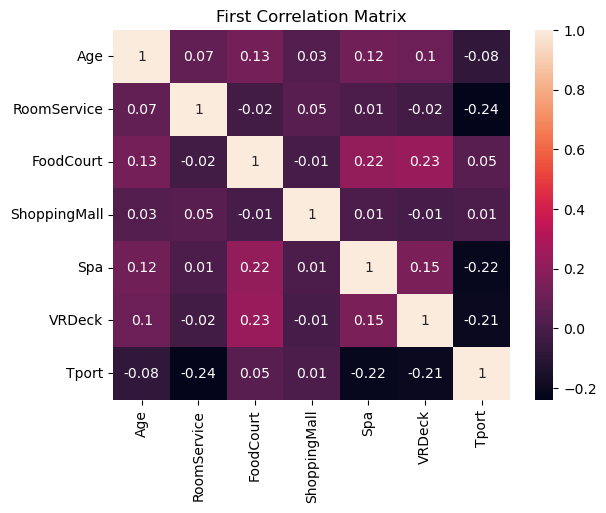

In [10]:
# plot a correlation matrix to get a clue
corr_m = train_data.corr(numeric_only=True).round(2)
fig, ax = plt.subplots()
plt.title("First Correlation Matrix")
sns.heatmap(corr_m, annot=True)

### Dealing with missing values
There are a lot of missing data in the table. Something has to be done about it. 

In [11]:
# fill in the missing category data
nanfiller = {
    "HomePlanet": "Unknown",
    "CryoSleep": "Unknown",
    "Cabin": "UK/UK/UK",
    "Destination": "Unknown",
    "VIP": "Unknown",
    'Name': "John Doh!"
}
for k in nanfiller.keys():
    train_data[k].fillna(value=nanfiller[k], inplace=True)
    test_data[k].fillna(value=nanfiller[k], inplace=True)


In [12]:
# For the missing values in spending we'll impute the missing values using the KNNImputer from scikit-learn
spending = ["RoomService","FoodCourt","ShoppingMall","Spa","VRDeck"]
imputer = KNNImputer()
X = imputer.fit_transform(train_data[spending])
train_data[spending] = X
X = imputer.fit_transform(test_data[spending])
test_data[spending] = X


In [13]:
# Impute the missing ages with a prediction based on spending habits
# idea from https://towardsdatascience.com/7-ways-to-handle-missing-values-in-machine-learning-1a6326adf79e
train_data_ages = train_data.dropna(axis='index', subset='Age')
y = train_data_ages["Age"]
X = train_data_ages[spending]


In [14]:
LR = LinearRegression()
LR.fit(X,y)
# test the thing
print(f"The age predictor score is {LR.score(X,y):.3f}")
train_age_hat = LR.predict(train_data[spending])
test_age_hat = LR.predict(test_data[spending])

The age predictor score is 0.036


In [15]:
# Convert the prediciotns to integers in a Pandas Series
train_age_hat = pd.Series(train_age_hat.astype(int), name="Age")
test_age_hat = pd.Series(test_age_hat.astype(int), name="Age")
# This part replaces the NaNs in the age with predicted values
filled_age = train_data["Age"].fillna(train_age_hat)
train_data["Age"] = filled_age
filled_age = test_data["Age"].fillna(test_age_hat)
test_data["Age"] = filled_age


Checking whether any NaN's persist in the data

In [16]:
train_data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Tport           0
Transported     0
dtype: int64

In [17]:
test_data.isna().sum()

PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64

Now all missing data has been handled.

### Splitting up the cabin codes
The cabin numbers are encoded as deck/number/side. We will split this into separate columns for better analysis oportunities. 

In [18]:
train_data[["Deck","CabNo", "Side"]] = train_data["Cabin"].str.split("/",expand=True)
train_data["CabNo"] = train_data["CabNo"].apply(pd.to_numeric,errors="coerce")
test_data[["Deck","CabNo", "Side"]] = train_data["Cabin"].str.split("/",expand=True)
test_data["CabNo"] = train_data["CabNo"].apply(pd.to_numeric,errors="coerce")

### EDA
Doing some exploratory data analysis with graphs to discover any relationships

<Axes: title={'center': 'Second Correlation Matrix Using Imputed Values'}>

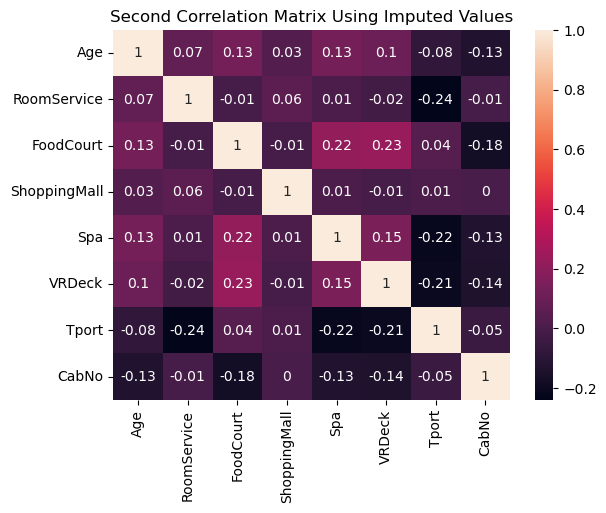

In [19]:
# plot a correlation matrix to get a clue
corr_m = train_data.corr(numeric_only=True).round(2)
fig, ax = plt.subplots()
plt.title("Second Correlation Matrix Using Imputed Values")
sns.heatmap(corr_m, annot=True)

The *Tport* field contains the class of interest, namely whether the Passenger was transported to safety or not. The highest correlations here are the amount the passenger spent at the Food Court, Spa, and VR Deck.

## Bar Charts
A series of charts displaying the percentage of people transported or not based on several criteria.

,Transported,Not Transported
Earth,0.423946,0.576054
Europa,0.658846,0.341154
Mars,0.523024,0.476976
Unknown,0.512438,0.487562


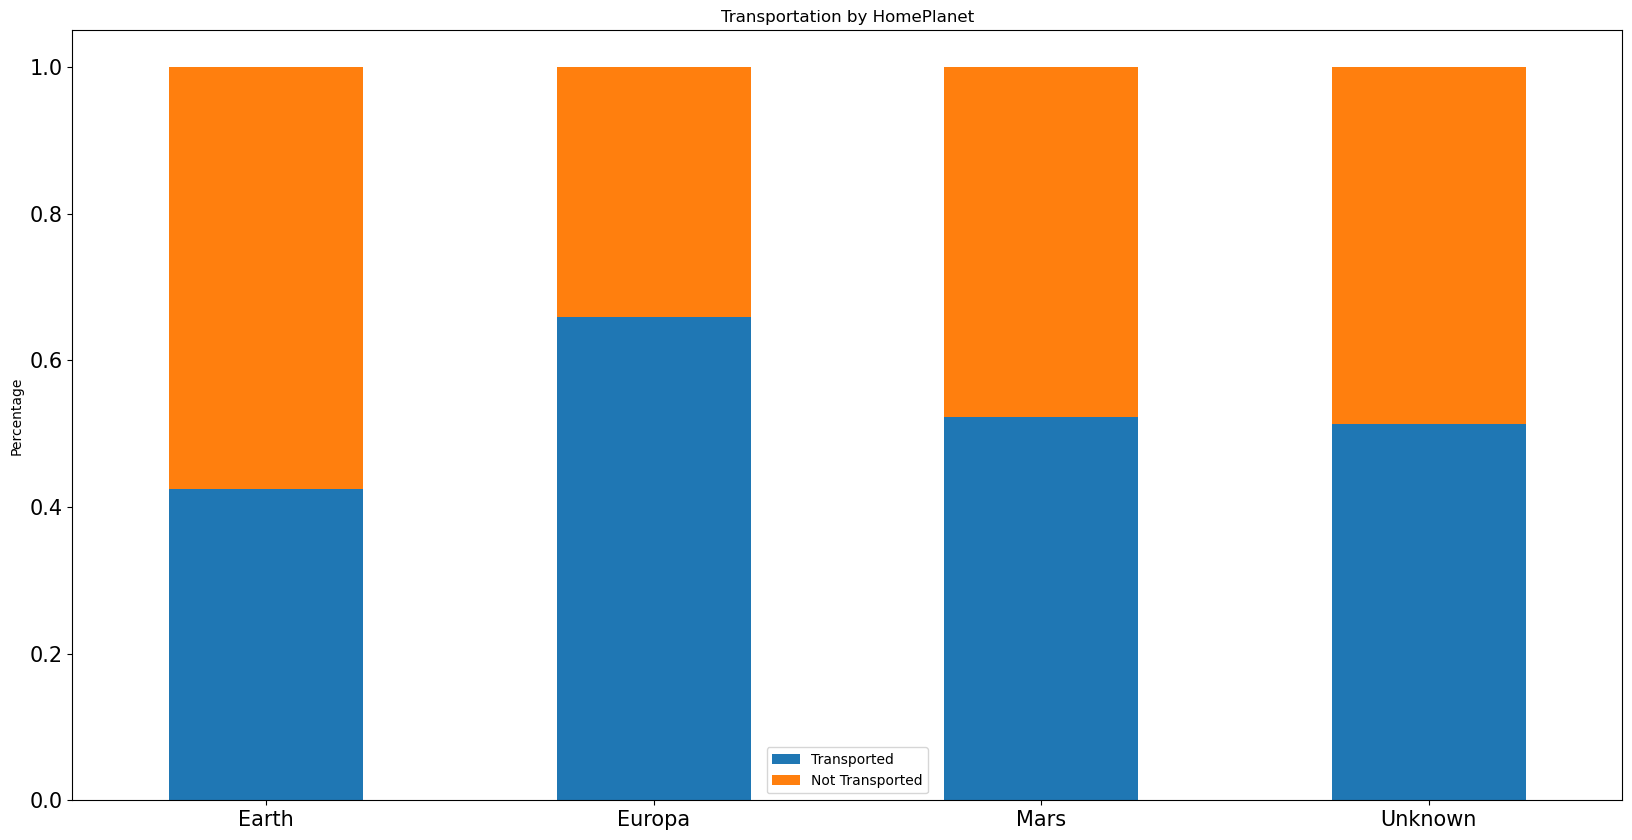

In [20]:
bar_chart_transported(train_data, "HomePlanet","Transported")

,Transported,Not Transported
55 Cancri e,0.610000,0.390000
PSO J318.5-22,0.503769,0.496231
TRAPPIST-1e,0.471175,0.528825
Unknown,0.505495,0.494505


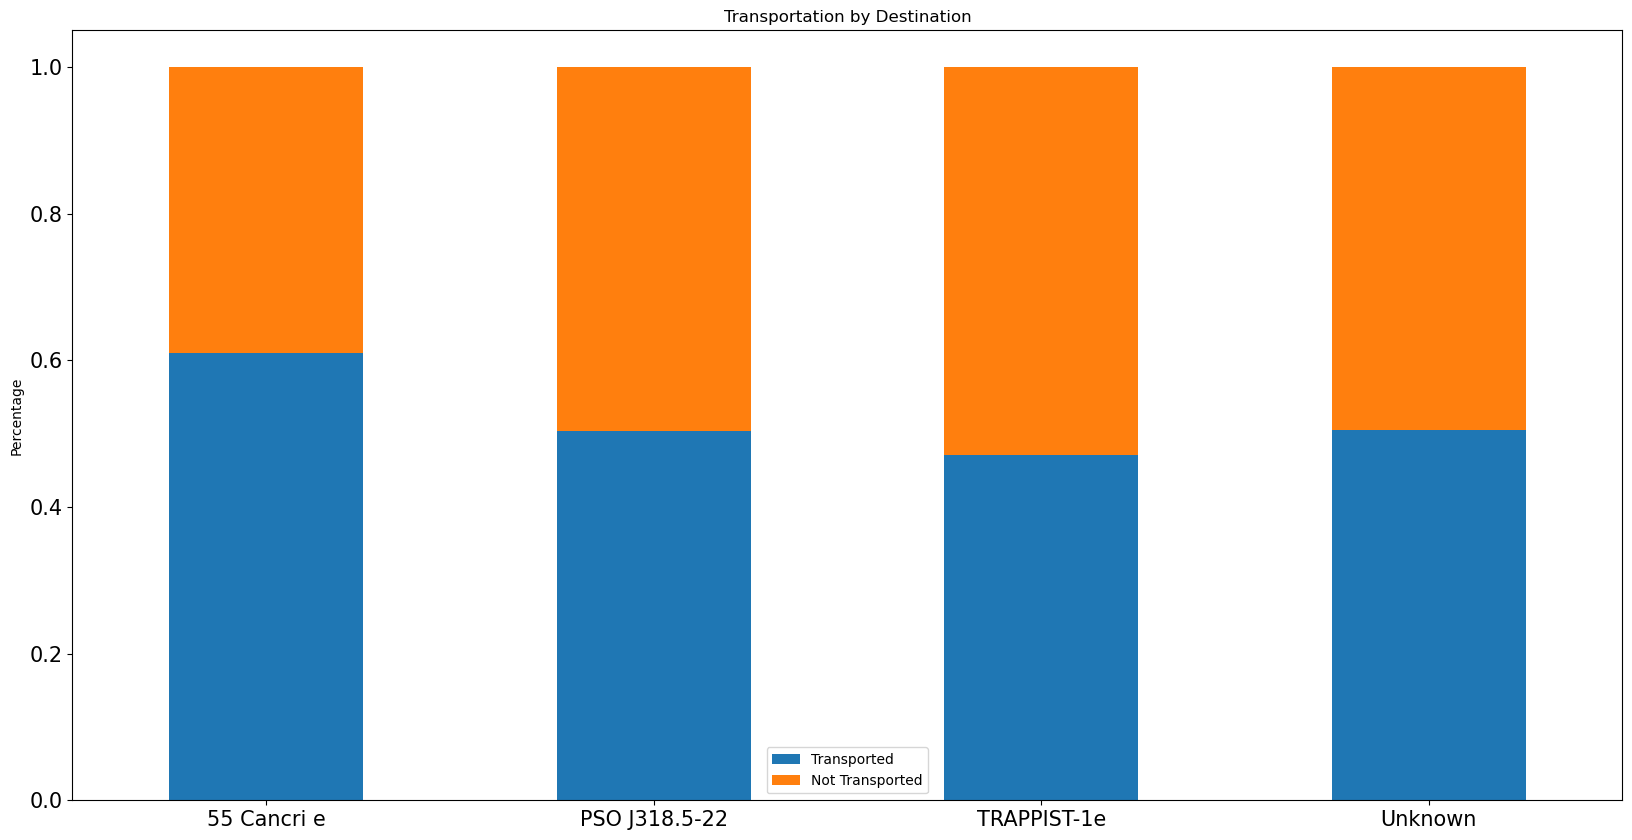

In [21]:
bar_chart_transported(train_data, "Destination","Transported")

,Transported,Not Transported
False,0.328921,0.671079
True,0.817583,0.182417
Unknown,0.488479,0.511521


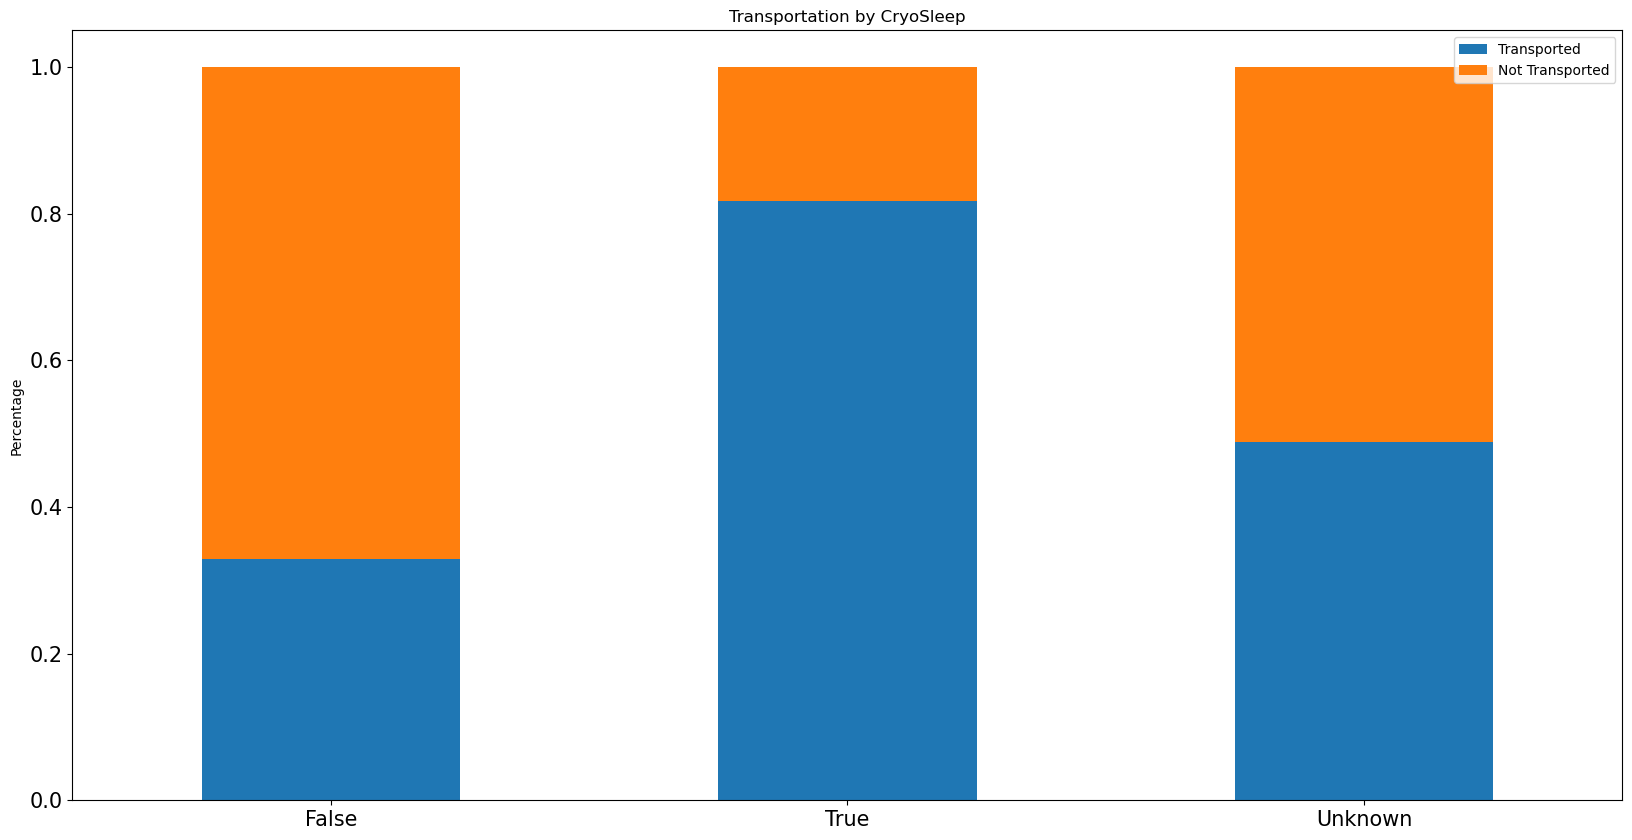

In [22]:
bar_chart_transported(train_data, "CryoSleep","Transported")

,Transported,Not Transported
False,0.506332,0.493668
True,0.381910,0.618090
Unknown,0.512315,0.487685


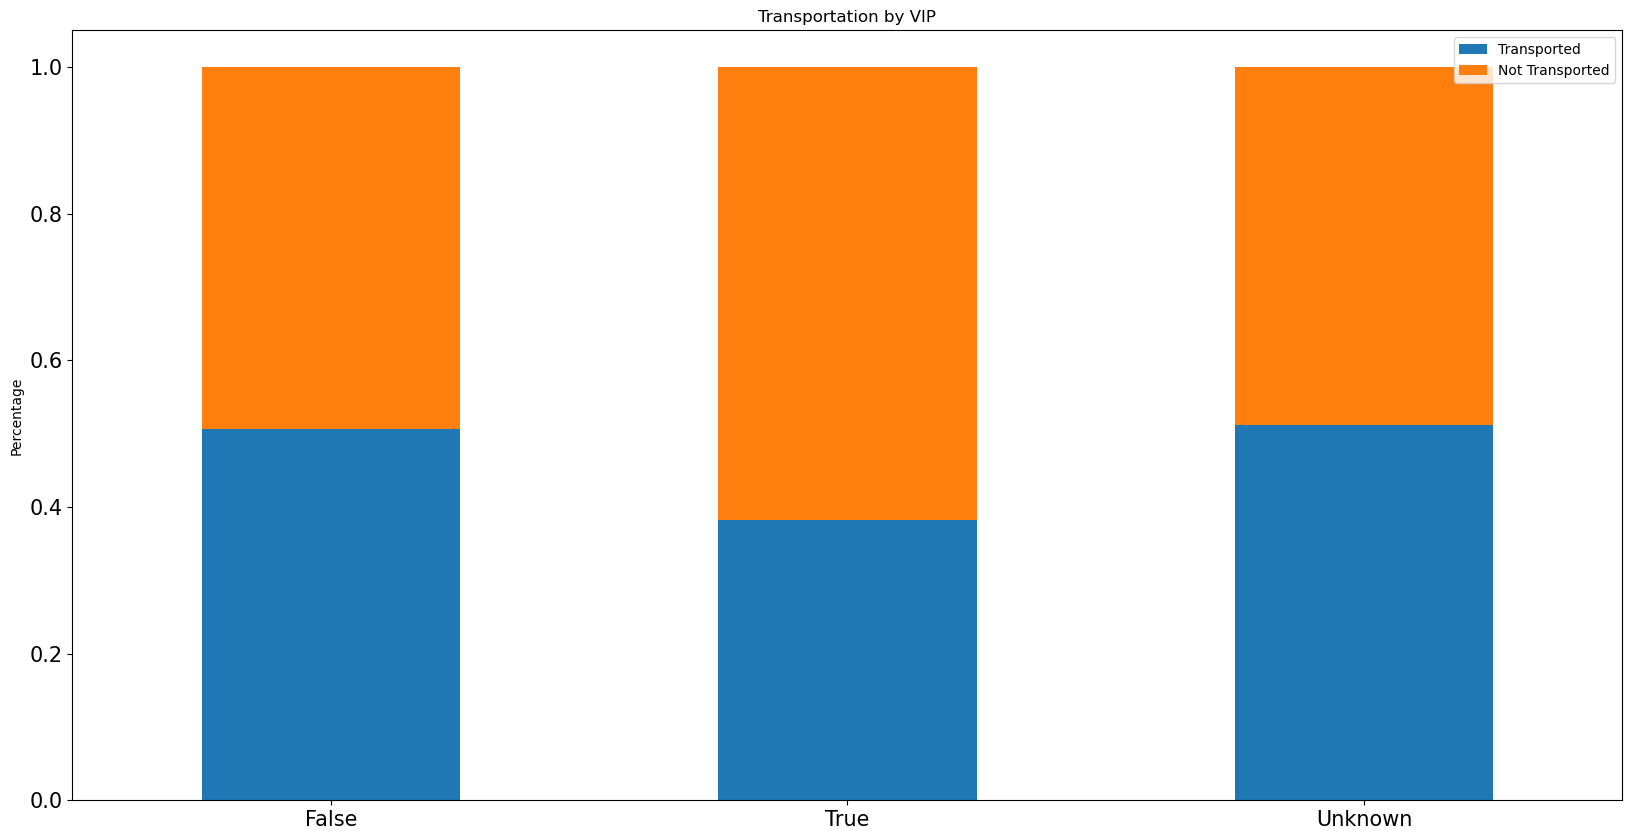

In [23]:
bar_chart_transported(train_data, "VIP","Transported")
    

## Scatter Plot and Strip Plot
Plots displaying spending habits versus age in various parts of the ship, color coded whether the passenger was trasnported or not.

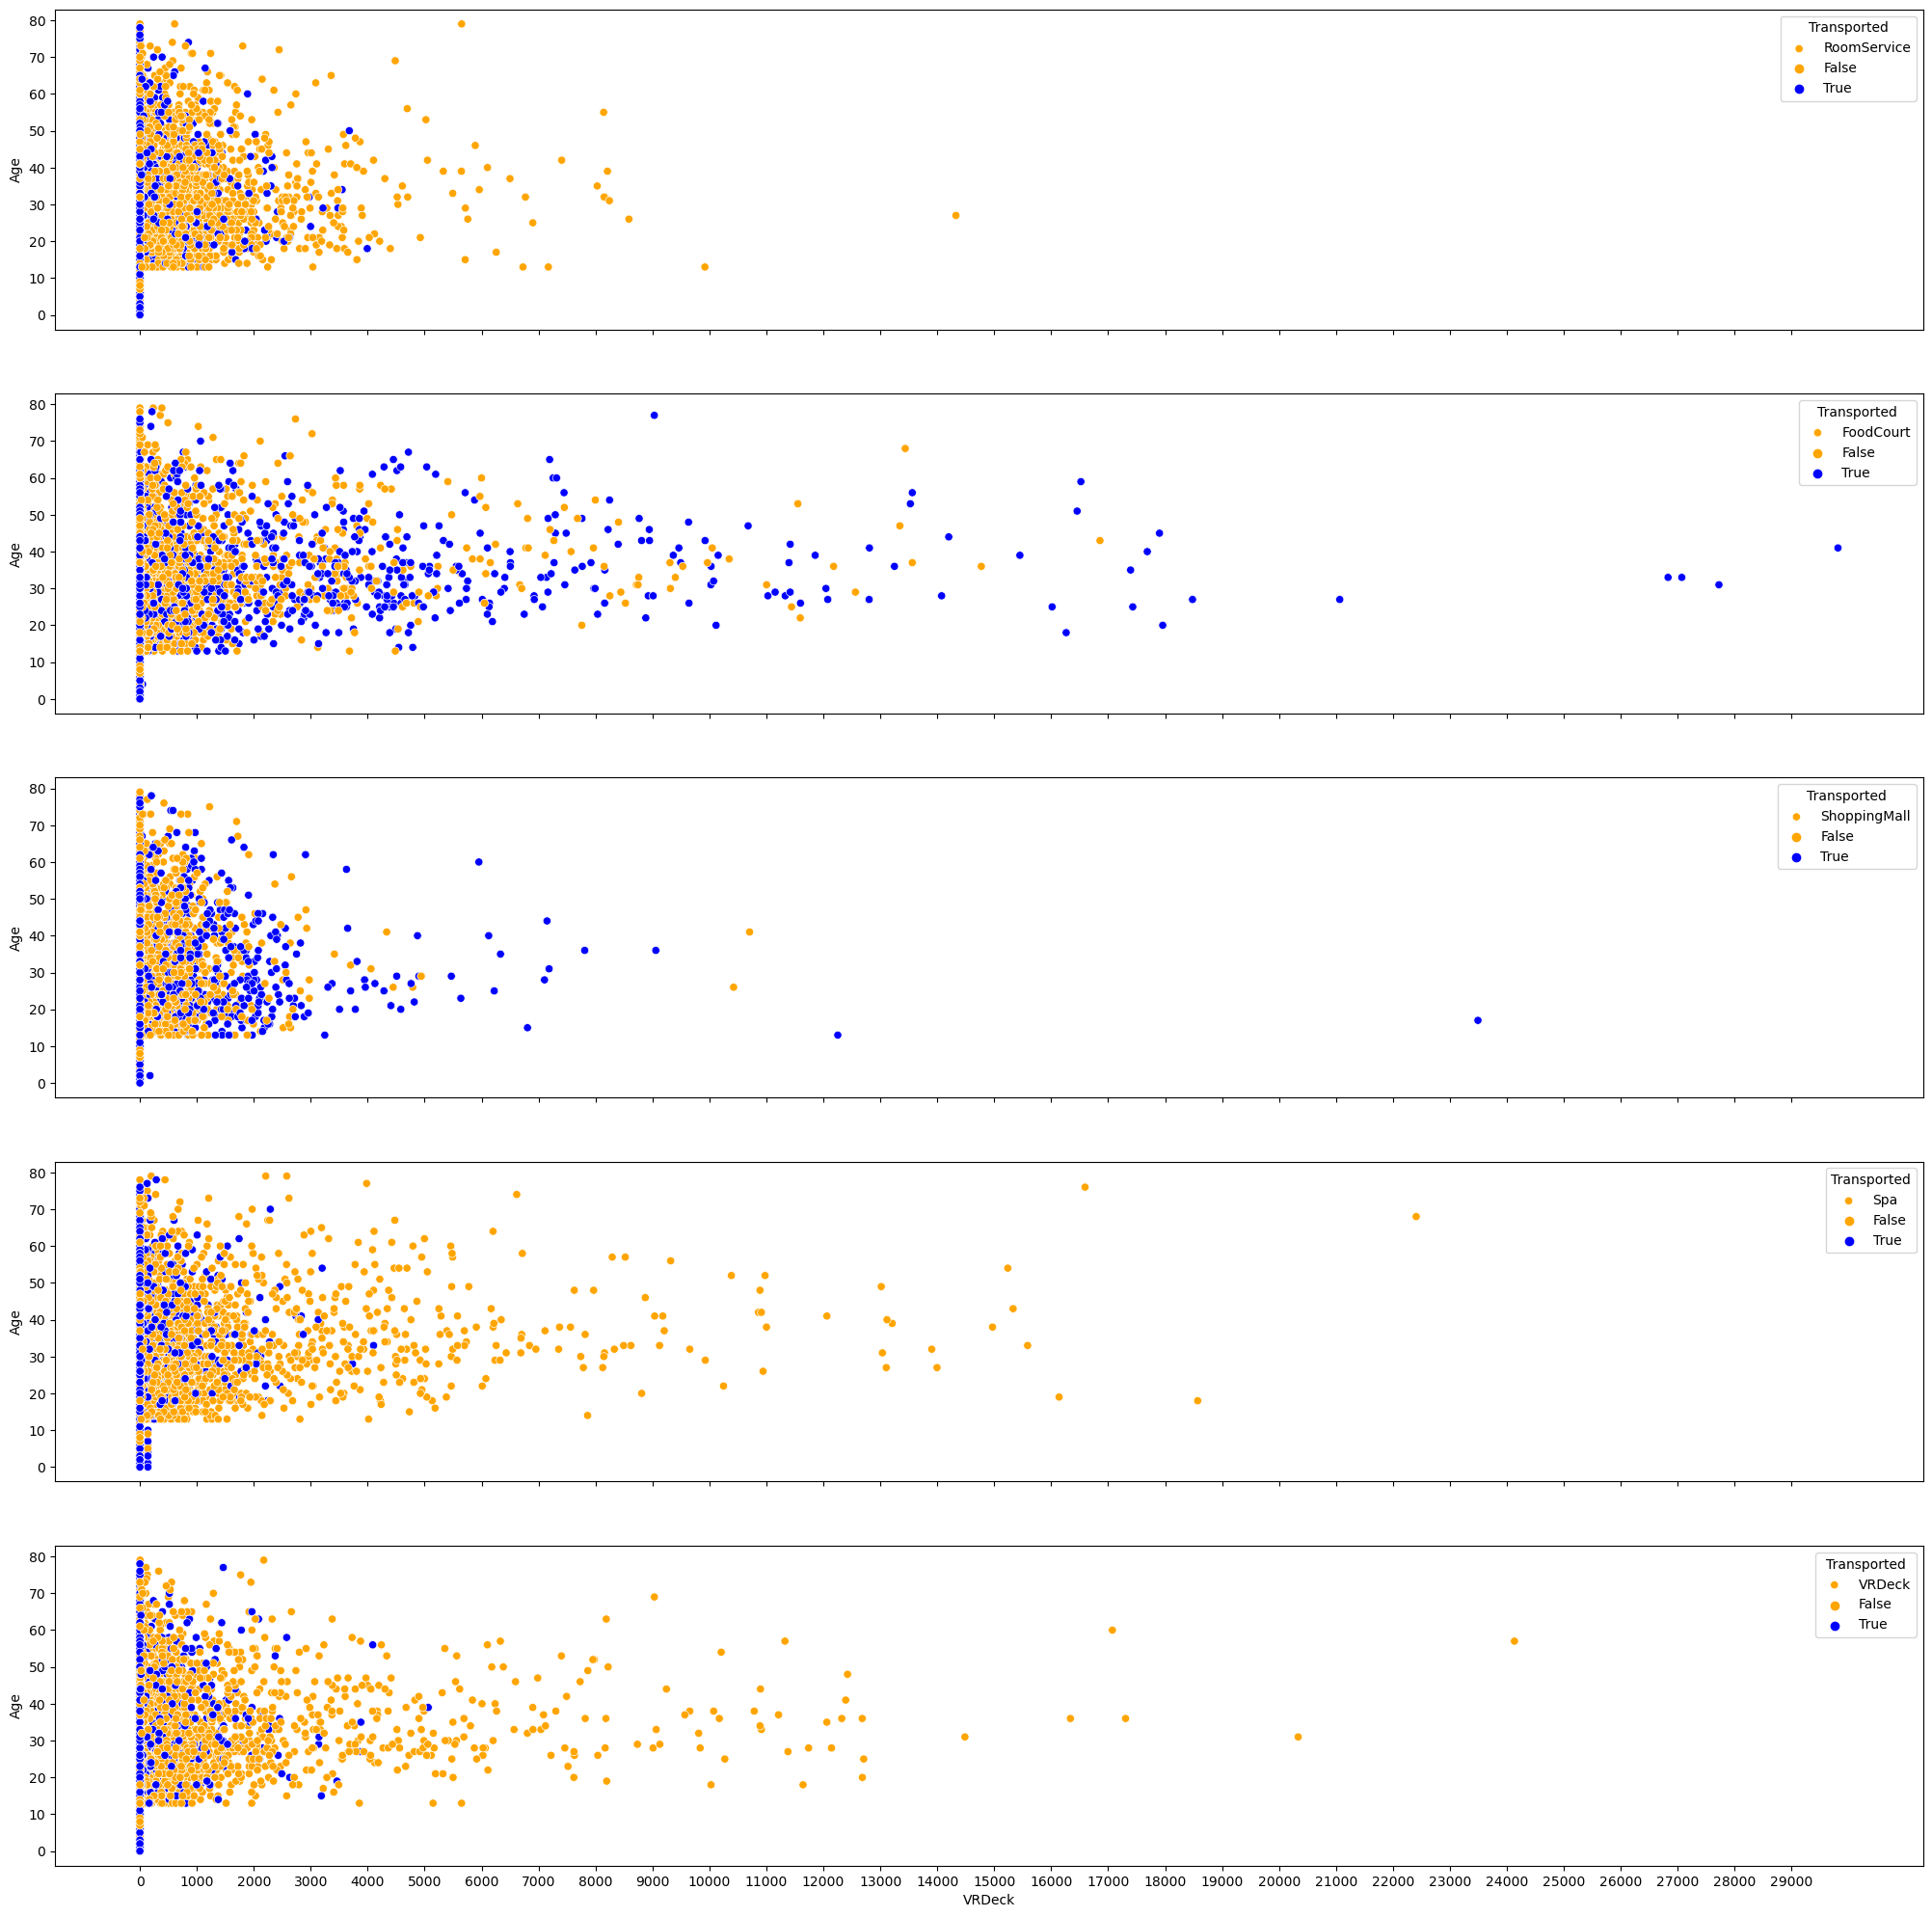

In [24]:
# plot Age v Spends
#  palette=["orange", "blue"],
categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spend_max = max(train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].max())
spend_labels = np.arange(0,spend_max,step=1000,dtype=np.int16)
fig, ax_ = plt.subplots(nrows=len(categories), ncols=1, figsize=(25,25), sharex=True)
# BEGIN = time.perf_counter()
for a in range(len(categories)):
    # begin = time.perf_counter()
    # print(f"Working on {categories[a]}")
    sns.scatterplot(data=train_data,x=categories[a], y="Age", hue="Transported", palette=["orange", "blue"], ax=ax_[a], label=categories[a] )
    # ax_[a].scatter(train_data[categories[a]],jitter, c=train_data["Transported"],alpha=0.75)
    # print(f"Finished with {categories[a]} after {(time.perf_counter() - begin):.3f} seconds.\n")
# plt.xlabel("Spend",fontsize=20)
# plt.ylabel("Age",fontsize=20)
plt.xticks(ticks=spend_labels, labels=spend_labels)
# print(f"Making all plots took {(time.perf_counter() - BEGIN):0.3f} seconds.")
plt.show()

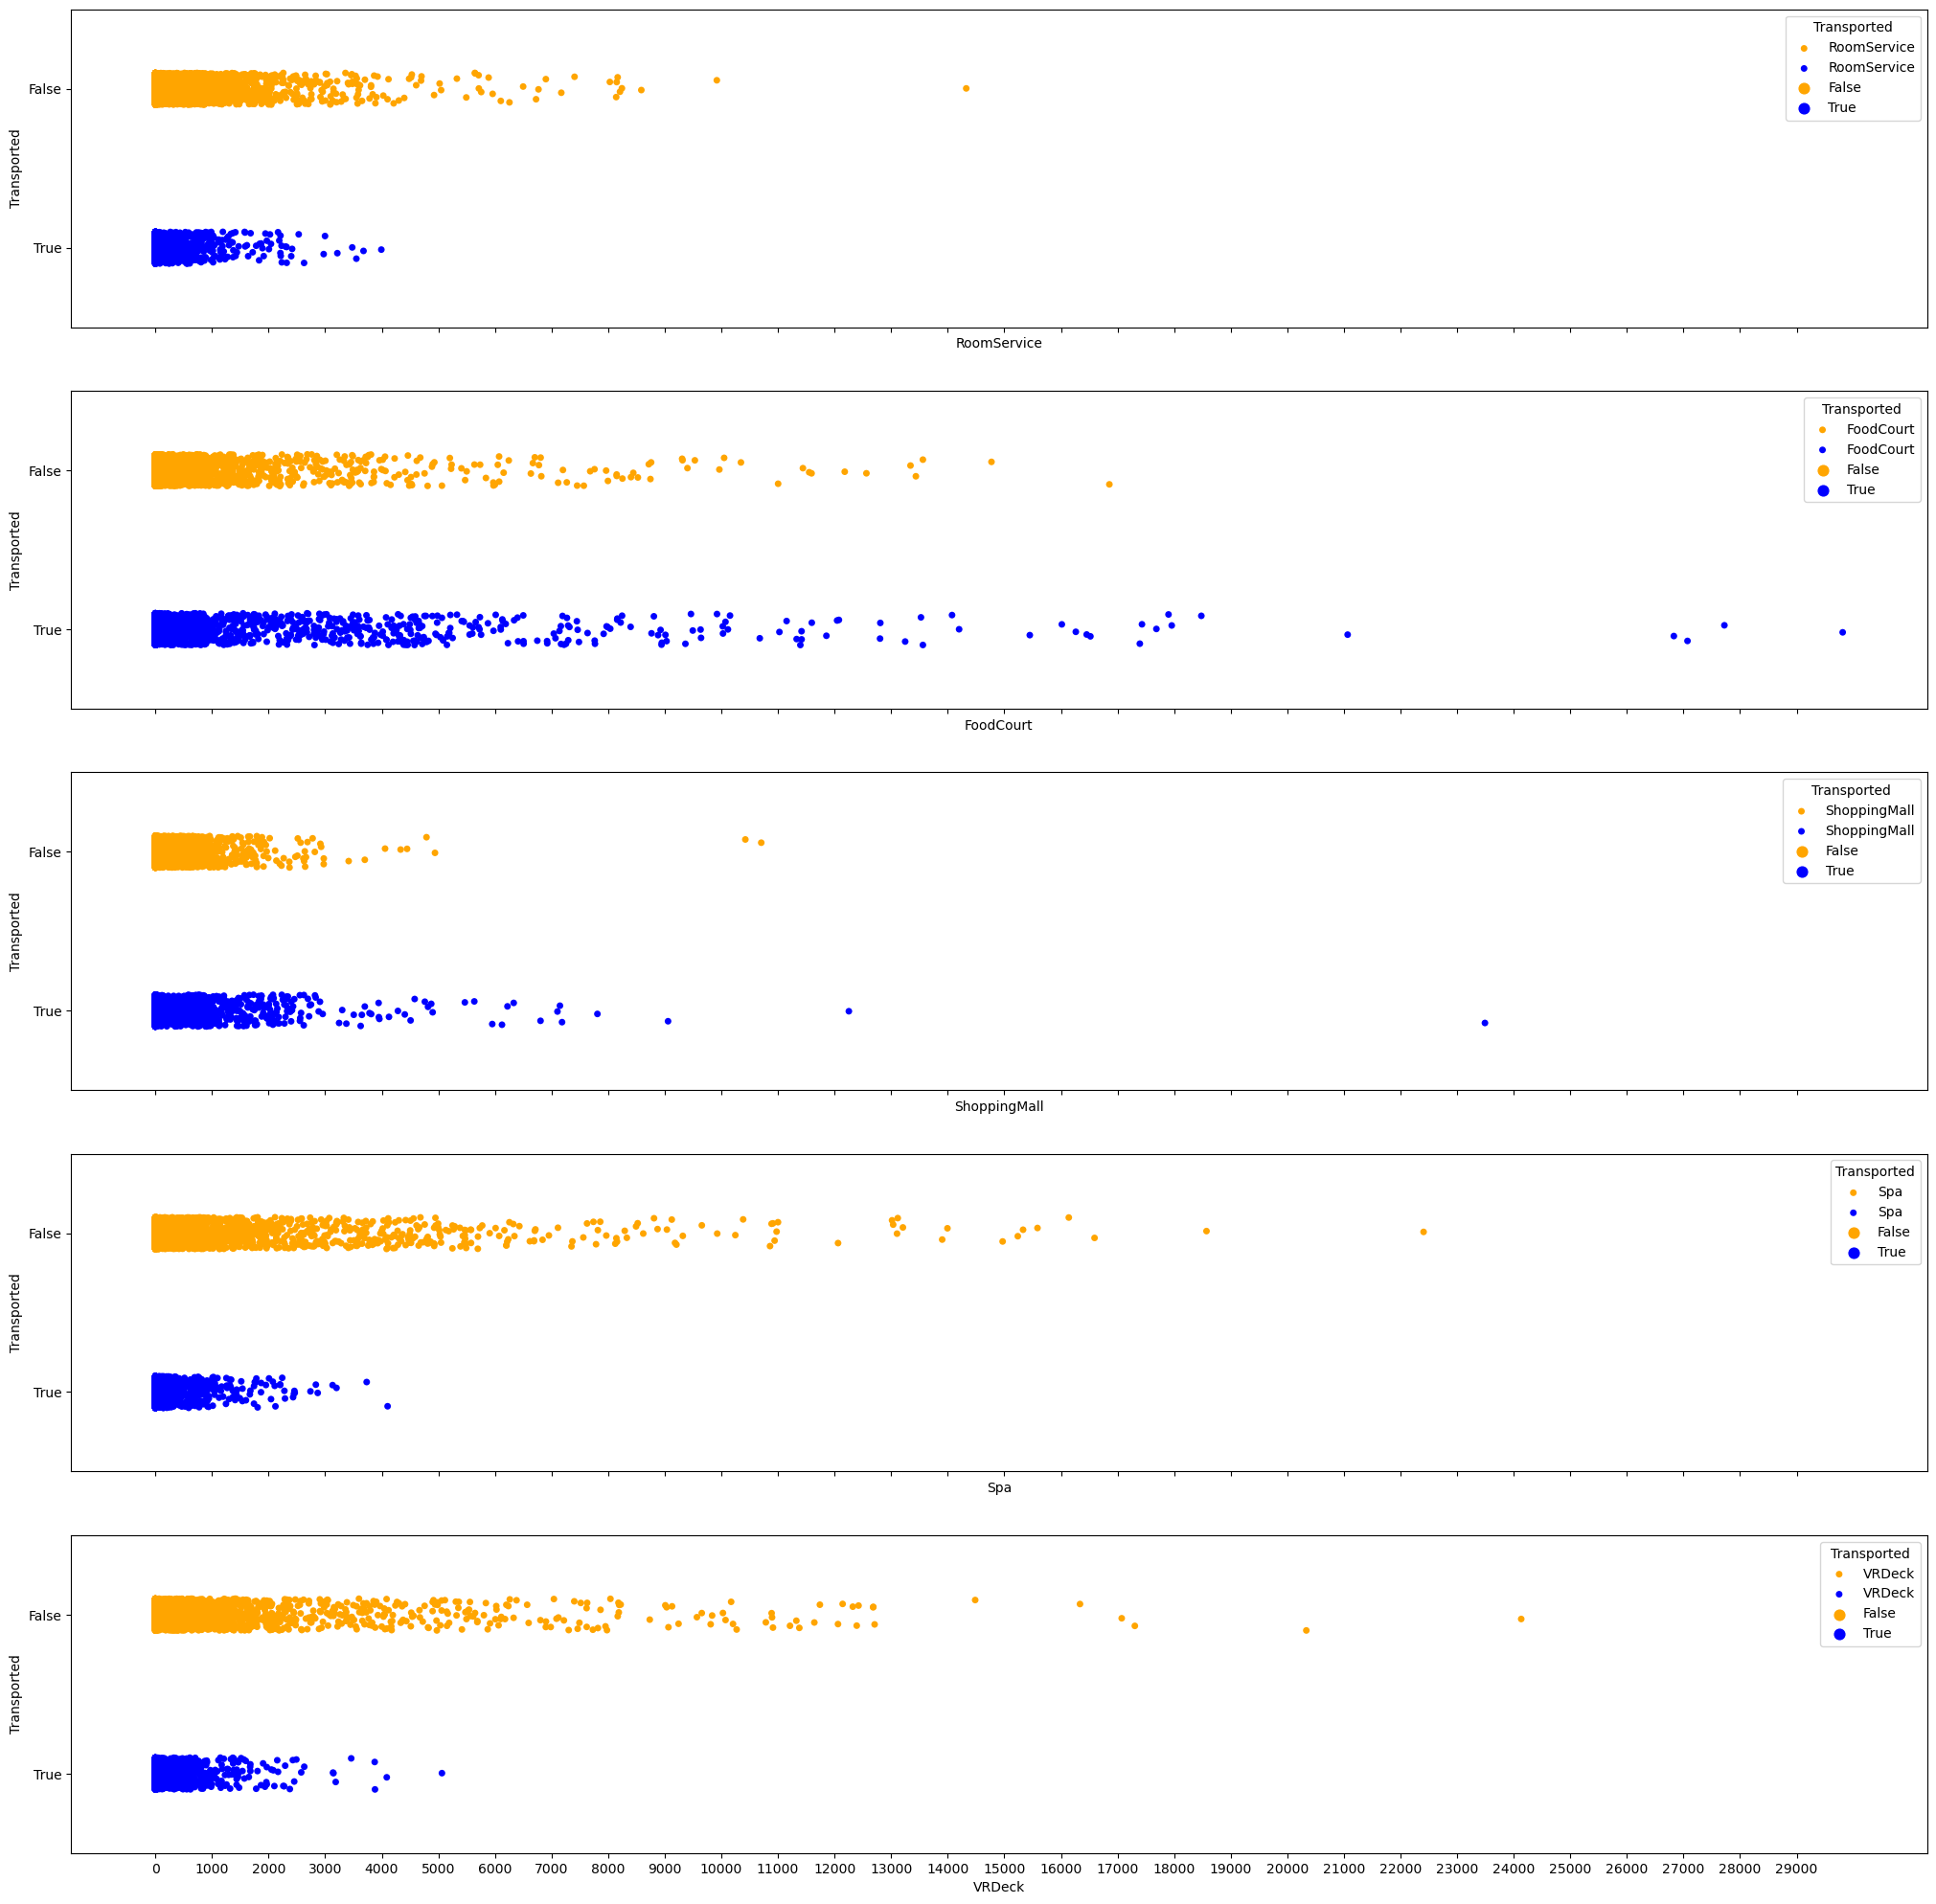

In [25]:
# plot Age v Spends
#  palette=["orange", "blue"],
categories = ['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']
spend_max = max(train_data[['RoomService', 'FoodCourt', 'ShoppingMall', 'Spa', 'VRDeck']].max())
spend_labels = np.arange(0,spend_max,step=1000,dtype=np.int16)
fig, ax_ = plt.subplots(nrows=len(categories), ncols=1, figsize=(25,25), sharex=True)
# BEGIN = time.perf_counter()
for a in range(len(categories)):
    # begin = time.perf_counter()
    # print(f"Working on {categories[a]}")
    sns.stripplot(data=train_data,x=categories[a], y="Transported", hue="Transported", palette=["orange", "blue"], ax=ax_[a], label=categories[a] )
    # ax_[a].scatter(train_data[categories[a]],jitter, c=train_data["Transported"],alpha=0.75)
    # print(f"Finished with {categories[a]} after {(time.perf_counter() - begin):.3f} seconds.\n")
# plt.xlabel("Spend",fontsize=20)
# plt.ylabel("Age",fontsize=20)
plt.xticks(ticks=spend_labels, labels=spend_labels)
# print(f"Making all plots took {(time.perf_counter() - BEGIN):0.3f} seconds.")
plt.show()

### Bin the spending habits that matter
Looking at the charts above it seems that no one was transported if they spent over a certain amount for Room Service, The Spa, and the VR Deck. So we'll bin on those categories at the highest spending level for those who were transported. 

In [26]:
cutnames = ["RoomService","Spa","VRDeck"]
for c in cutnames:
    midcut = (train_data[train_data["Transported"] == "True"][c].max() * 1.1)
    maxcut = train_data[c].max() * 1.1
    train_data[(c + "_bin")] = pd.cut(train_data[c], [-1, midcut, maxcut], labels=["low","high"])
    test_data[(c + "_bin")] = pd.cut(test_data[c], [-1, midcut, maxcut], labels=["low","high"])
    
y = train_data["Tport"].to_numpy()
X = pd.get_dummies(train_data, columns=["HomePlanet", "CryoSleep", "Destination","VIP","RoomService_bin","Spa_bin","VRDeck_bin","Deck","Side"])
X.drop(columns=["PassengerId", "Cabin","Name","Transported", "Tport","RoomService","Spa","VRDeck","ShoppingMall","FoodCourt", "CabNo"], inplace=True)


## Scaling the data for better processing

In [27]:
scaler = preprocessing.MinMaxScaler()
X_scaled = scaler.fit_transform(X)
# per the docs c-contiguous arrays prevent an internal copy operation for training
X_scaled = np.ascontiguousarray(X_scaled)
xtrain, xtest, ytrain, ytest = train_test_split(X_scaled, y, test_size=0.40)

## Grid Search with Cross Validation for Optimal Hyper-parameters
It runs the search

In [28]:
# the list this function returns are dicts of predictors, scores, f_ones, yhats
startit = time.perf_counter()
grid_results = list(rungrids(xtrain, xtest, ytrain, ytest))
endit = time.perf_counter()
grid_elapsed = endit - startit
print(f"Elapsed time for running all the grid searches is {grid_elapsed:0.2f} seconds")

Fitting logr
Fitting dt
Fitting svm


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting knn
Fitting rf


/usr/local/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Fitting sgd
Elapsed time for running all the grid searches is 325.99 seconds


It determines which model has the best score

In [29]:

best_model_id = max(grid_results[2], key=grid_results[2].get) # get the key for the top F1 score
f1_ = grid_results[2][best_model_id] # get the value for the top F1 score
score_ = grid_results[1][best_model_id] # get the value for the model score associated with the top F1 score


In [30]:
print(" Best model is ", best_model_id)
print(f" The F1 score is {f1_:.3f}")
print(f" The model's score is {score_:.3f}")
best_model = grid_results[0][best_model_id].best_estimator_
best_params = grid_results[0][best_model_id].best_params_

 Best model is  logr
 The F1 score is 0.718
 The model's score is 0.739


In [31]:
best_model

LogisticRegression(C=0.1, max_iter=500, penalty='l1', solver='liblinear')

In [32]:
best_params

{'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}

### Halving Grid Search
It runs the search

In [33]:
# the list this function returns are dicts of predictors, scores, f_ones, yhats
startit = time.perf_counter()
half_grid_results = list(run_half_grids(xtrain, xtest, ytrain, ytest))
endit = time.perf_counter()
half_grid_elapsed = endit - startit
print(f"Elapsed time for running all the halving grid searches is {half_grid_elapsed:0.2f} seconds")

Fitting logr
Fitting dt
Fitting svm
Fitting knn
Fitting rf
Fitting sgd
Elapsed time for running all the halving grid searches is 130.23 seconds


It determines which model has the best score

In [34]:

half_best_model_id = max(half_grid_results[2], key=half_grid_results[2].get) # get the key for the top F1 score
half_f1_ = half_grid_results[2][best_model_id] # get the value for the top F1 score
half_score_ = half_grid_results[1][best_model_id] # get the value for the model score associated with the top F1 score


In [35]:
print(" Best model is ", half_best_model_id)
print(f" The F1 score is {half_f1_:.3f}")
print(f" The model's score is {half_score_:.3f}")
half_best_model = grid_results[0][half_best_model_id].best_estimator_
half_best_params = grid_results[0][half_best_model_id].best_params_

 Best model is  logr
 The F1 score is 0.719
 The model's score is 0.738


### Random Search With Cross Validation for Optimal Hyper-parameters
We'll compare the performance of RandomizedSearchCV


In [37]:
# the list this function returns are dicts of predictors, scores, f_ones, yhats
startit = time.perf_counter()
rand_grid_results = list(runrandoms(xtrain, xtest, ytrain, ytest))
endit = time.perf_counter()
random_elapsed = endit - startit
print(f"Elapsed time for running all the random searches is {random_elapsed:0.2f} seconds")

Fitting logr
Fitting dt
Fitting svm


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting knn
Fitting rf
Fitting sgd


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=10. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Elapsed time for running all the random searches is 34.30 seconds


In [38]:

rand_best_model_id = max(rand_grid_results[2], key=rand_grid_results[2].get) # get the key for the top F1 score
rand_f1_ = rand_grid_results[2][rand_best_model_id] # get the value for the top F1 score
rand_score_ = rand_grid_results[1][rand_best_model_id] # get the value for the model score associated with the top F1 score


In [39]:
print(" Best model is ", rand_best_model_id)
print(f" The F1 score is {rand_f1_:.3f}")
print(f" The model's score is {rand_score_:.3f}")
rand_best_model = grid_results[0][rand_best_model_id].best_estimator_
rand_best_params = grid_results[0][rand_best_model_id].best_params_

 Best model is  svm
 The F1 score is 0.726
 The model's score is 0.741


### Halving Random Search
Using the experimental Halving Random Search.

In [40]:
# the list this function returns are dicts of predictors, scores, f_ones, yhats
startit = time.perf_counter()
half_rand_grid_results = list(run_half_randoms(xtrain, xtest, ytrain, ytest))
endit = time.perf_counter()
half_random_elapsed = endit - startit
print(f"Elapsed time for running all the halving random searches is {half_random_elapsed:0.2f}")

Fitting logr


/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1173: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/usr/local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


Fitting dt
Fitting svm


/usr/local/lib/python3.9/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=10000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Fitting knn


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:952: UserWarning: One or more of the test scores are non-finite: [0.65 0.65 0.65 0.65 0.6  0.6  0.5  0.5  0.65 0.45 0.65 0.65 0.65 0.55
 0.65 0.5  0.6  0.65 0.65 0.65 0.65 0.5  0.65  nan 0.5  0.65  nan  nan
 0.65 0.65 0.6   nan 0.6  0.6  0.6  0.5  0.65 0.65 0.45 0.65 0.5  0.65
 0.55 0.65  nan 0.6   nan 0.65 0.6  0.6  0.6   nan 0.6   nan  nan 0.5
 0.65 0.45 0.6  0.65 0.5  0.65 0.6  0.6  0.45 0.6  0.65 0.6  0.5   nan
 0.65 0.55 0.65  nan  nan 0.55 0.65 0.55  nan 0.65  nan 0.6  0.65 0.65
 0.5   nan  nan 0.5  0.65  nan 0.45 0.65 0.6  0.6  0.45 0.65 0.6  0.65
 0.6  0.5  0.5  0.55 0.6  0.5  0.6  0.65 0.6  0.55  nan 0.6  0.55  nan
 0.6  0.55 0.6  0.6   nan 0.55  nan 0.65 0.65  nan 0.65 0.6  0.5  0.5
 0.65  nan 0.65 0.65 0.6   nan 0.45 0.6  0.65 0.65 0.65 0.65  nan 0.65
 0.65 0.65 0.55 0.65 0.5  0.6  0.55 0.45 0.5   nan 0.55  nan 0.5  0.6
 0.5  0.65  nan  nan  nan 0.65 0.65 0.45 0.65 0.5  0.65 0.65 0.6  0.55
 0.6  0.65 0

Fitting rf
Fitting sgd
Elapsed time for running all the halving random searches is 159.17


/usr/local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 5 is smaller than n_iter=260. Running 5 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [41]:

half_rand_best_model_id = max(half_rand_grid_results[2], key=half_rand_grid_results[2].get) # get the key for the top F1 score
half_rand_f1_ = half_rand_grid_results[2][half_rand_best_model_id] # get the value for the top F1 score
half_rand_score_ = half_rand_grid_results[1][half_rand_best_model_id] # get the value for the model score associated with the top F1 score


In [42]:
print(" Best model is ", half_rand_best_model_id)
print(f" The F1 score is {half_rand_f1_:.3f}")
print(f" The model's score is {half_rand_score_:.3f}")
half_rand_best_model = grid_results[0][half_rand_best_model_id].best_estimator_
half_rand_best_params = grid_results[0][half_rand_best_model_id].best_params_

 Best model is  logr
 The F1 score is 0.719
 The model's score is 0.734


## Summary of Parameter Search Processing Times

In [43]:
print(f"GridSearchCV completed in {grid_elapsed:0.2f} seconds with f1 score {score_:0.3f} --> ", best_model_id)
print(f"HalvingGridSearchCV completed in {half_grid_elapsed:0.2f} seconds with f1 score {half_score_:0.3f} --> ", half_best_model_id)
print(f"RandomizedSearchCV completed in {random_elapsed:0.2f} seconds with f1 score {rand_score_:0.3f} --> ", rand_best_model_id)
print(f"HalvingRandomSearchCV completed in {half_random_elapsed:0.2f} seconds with f1 score {half_rand_score_:0.3f} --> ", half_rand_best_model_id)

GridSearchCV completed in 325.99 seconds with f1 score 0.739 -->  logr
HalvingGridSearchCV completed in 130.23 seconds with f1 score 0.738 -->  logr
RandomizedSearchCV completed in 34.30 seconds with f1 score 0.741 -->  svm
HalvingRandomSearchCV completed in 159.17 seconds with f1 score 0.734 -->  logr


## Make the predictions and export the results

In [44]:
X = pd.get_dummies(test_data, columns=["HomePlanet", "CryoSleep", "Destination","VIP","RoomService_bin","Spa_bin","VRDeck_bin","Deck","Side"])
X.drop(columns=["PassengerId", "Cabin","Name","RoomService","Spa","VRDeck","ShoppingMall","FoodCourt", "CabNo"], inplace=True)
X_scaled = scaler.transform(X)
# per the docs c-contiguous arrays prevent an internal copy operation for training
X_scaled = np.ascontiguousarray(X_scaled)
yhat = best_model.predict(X_scaled)


An example of the required output format for the predictions/

In [45]:
sample_data

,PassengerId,Transported
0,0013_01,False
1,0018_01,False
2,0019_01,False
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,False
4273,9269_01,False
4274,9271_01,False
4275,9273_01,False


In [46]:
sample_data.dtypes

PassengerId    object
Transported      bool
dtype: object

### Prepare the Output Dataframe 

In [47]:
submission_data = pd.DataFrame(test_data.PassengerId)
submission_data["Transported"]= yhat
submission_data

,PassengerId,Transported
0,0013_01,1
1,0018_01,0
2,0019_01,1
3,0021_01,0
4,0023_01,0
...,...,...
4272,9266_02,1
4273,9269_01,0
4274,9271_01,1
4275,9273_01,0


Cast the results of the prediction as boolean values

In [48]:
submission_data["Transported"] = submission_data["Transported"].astype("bool")

In [49]:
submission_data

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,False
4,0023_01,False
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,False


In [50]:
# Write the submission file 
submission_data.to_csv("submission_data.csv", index=False)

## And that is the end of the story.